In [2]:
from models.util import create_model, load_state_dict
import torch
import numpy as np
from src.train.video_warp_dataset import *
import matplotlib.pyplot as plt
import os
from annotator.util import HWC3
from utils.share import *
import utils.config as config
import einops
import cv2

In [3]:
def visualize_feature_maps(tensor, title="Features", num_channels=4, save_path=None):
    """
    Visualize and optionally save the first `num_channels` feature maps from a tensor.
    
    Args:
        tensor: torch.Tensor of shape [B, C, H, W]
        title: Title prefix for each subplot
        num_channels: Number of channels to visualize (default: 4)
        save_path: If provided, saves the figure to this path (e.g., 'output/features.png')
    """
    assert tensor.ndim == 4, "Tensor must be of shape [B, C, H, W]"
    tensor = tensor.detach().cpu().squeeze(0)  # [C, H, W]

    plt.figure(figsize=(num_channels * 3, 3))
    for i in range(num_channels):
        feature_map = tensor[i]  # [H, W]
        feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min() + 1e-5)

        plt.subplot(1, num_channels, i + 1)
        plt.imshow(feature_map.numpy(), cmap='gray')
        plt.title(f"{title} - C{i}")
        plt.axis('off')

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300)
        print(f"Saved: {save_path}")
    else:
        plt.show()

def load_model(config_path, ckpt_path):
    model = create_model(config_path).cpu()
    ckpt = load_state_dict(ckpt_path, location='cuda')
    model.load_state_dict(ckpt, strict=False)
    return model.cuda()

def prepare_local_conditions(image_paths, size=(512, 512)):
    local_images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, size)
        detected = HWC3(img)
        local_images.append(detected)
    combined = np.concatenate(local_images, axis=2)
    tensor = torch.from_numpy(combined.copy()).float().cuda() / 255.0
    tensor = torch.stack([tensor], dim=0)  # batch size 1
    tensor = einops.rearrange(tensor, "b h w c -> b c h w").clone()
    return tensor

def load_flow(flow_path, size=(128, 128)):
    flow = process_flow_with_scaling(flow_path, target_shape=size)  # must match feature resolution
    flow_tensor = torch.from_numpy(flow).float().cuda().unsqueeze(0)  # [1, 2, H, W]
    return flow_tensor

In [3]:
model_warp = load_model('configs/bi_directional_warp/uni_v15.yaml', 'experiments/bi_directional_warp/uni.ckpt' )

No module 'xformers'. Proceeding without it.
UniControlNet: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /data/maryam.sana/anaconda3/envs/unicontrolwrap/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /data/maryam.sana/anaconda3/envs/unicontrolwrap/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
Loaded model config from [configs/bi_directional_warp/uni_v15.yaml]
Loaded state_dict from [experiments/bi_directional_warp/uni.ckpt]


AttributeError: 'UniControlNet' object has no attribute 'feature_extractor'

In [12]:
feature_extractor = model_warp.local_adapter.feature_extractor.cuda()
depth_extractor = feature_extractor.depth_extractor.cuda()
wrapper = feature_extractor.wrapper.cuda()
fusion = feature_extractor.fusion.cuda()
extractor = feature_extractor.extractors[0].cuda()

In [13]:
local_img_paths = [
    'data/sequences/00009/0348/r1.png',
    'data/sequences/00009/0348/depth/im5_depth.png'
]
flow_path = 'data/sequences/00009/0348/Flow/im5.flo'
prompt = 'a man with hand on his head'

local_control= prepare_local_conditions(local_img_paths )
flow_control = load_flow(flow_path)

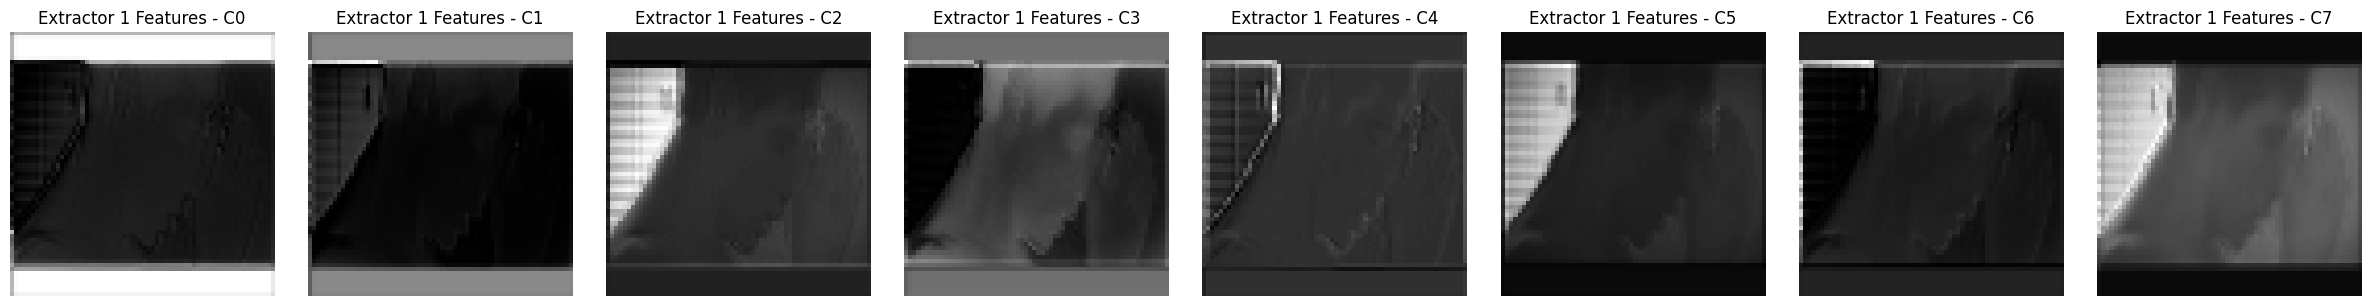

In [14]:
frame_features = feature_extractor.pre_extractor(local_control[:,:3,:,:],None) 
# depth_features = depth_extractor(local_control[:,3:,:,:],None) 
warped_features = wrapper(frame_features, flow_control)
# fused_features = torch.cat([warped_features,depth_features],dim=1)
# fusion_ft = fusion(fused_features)
extracted_ft = extractor(warped_features,None)

visualize_feature_maps(extracted_ft, title="Extractor 1 Features", num_channels=8)

In [4]:
config_path= 'configs/bi_directional/uni_v15.yaml'
ckpt ='experiments/bi_directional/uni.ckpt' 

model_bi = create_model(config_path).cpu()
ckpt = load_state_dict(ckpt, location='cuda')
model_bi = model_bi.cuda()

No module 'xformers'. Proceeding without it.
UniControlNet: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /data/maryam.sana/anaconda3/envs/unicontrolwrap/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /data/maryam.sana/anaconda3/envs/unicontrolwrap/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
Loaded model config from [configs/bi_directional/uni_v15.yaml]
Loaded state_dict from [experiments/bi_directional/uni.ckpt]


In [5]:
feature_extractor = model_bi.local_adapter.feature_extractor.cuda()
pre_extractor = feature_extractor.pre_extractor.cuda()
extractors = feature_extractor.extractors.cuda()

In [6]:
local_images = ['data/sequences/00009/0348/r1.png','data/sequences/00009/0348/r2.png','data/sequences/00009/0348/Flow/im5.png']
prompt = 'a man with hand on this head' 
local_control = prepare_local_conditions(local_images)

In [7]:
out2 = feature_extractor(local_control)

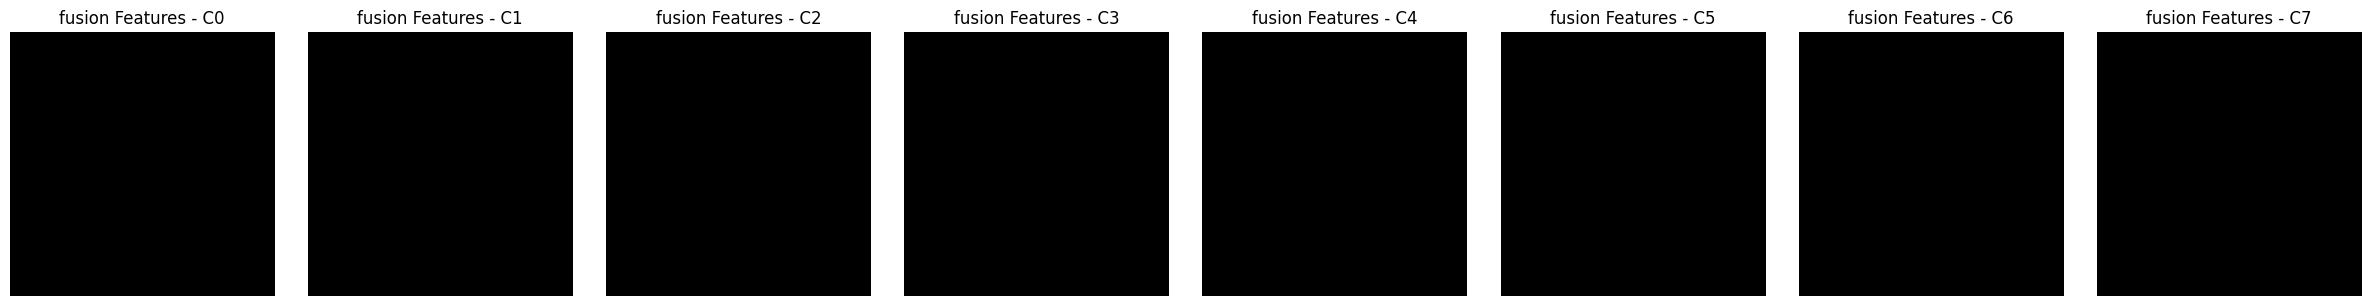

In [8]:
visualize_feature_maps(out2[3], title="fusion Features", num_channels=8)

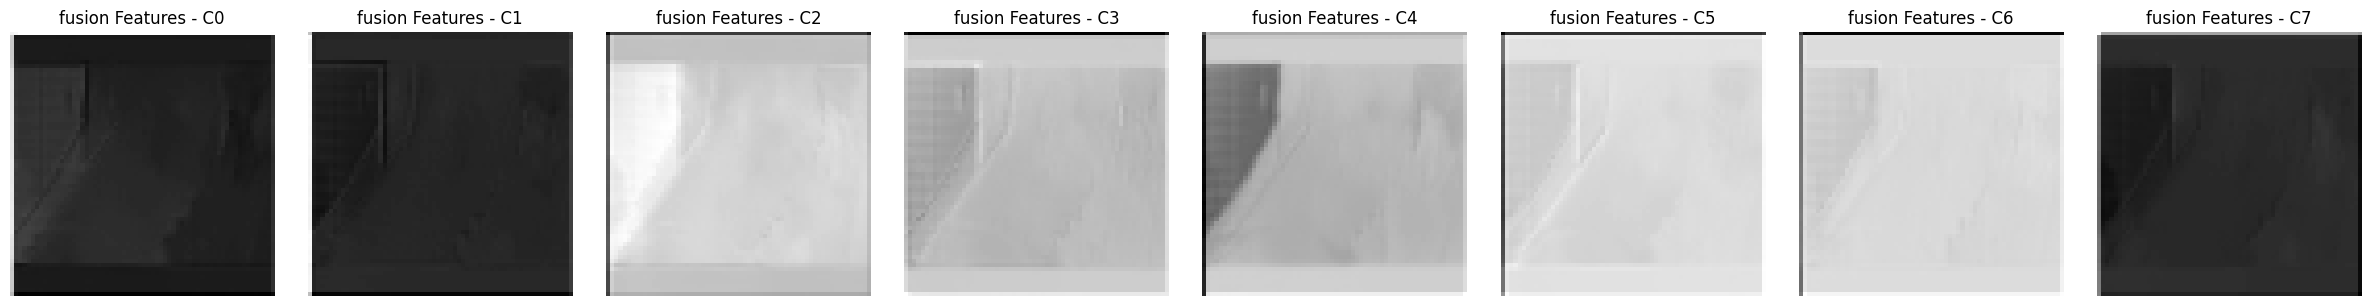

In [9]:
e1= extractors[0](feature_extractor.pre_extractor(local_control,None),None)
visualize_feature_maps(e1, title="fusion Features", num_channels=8)

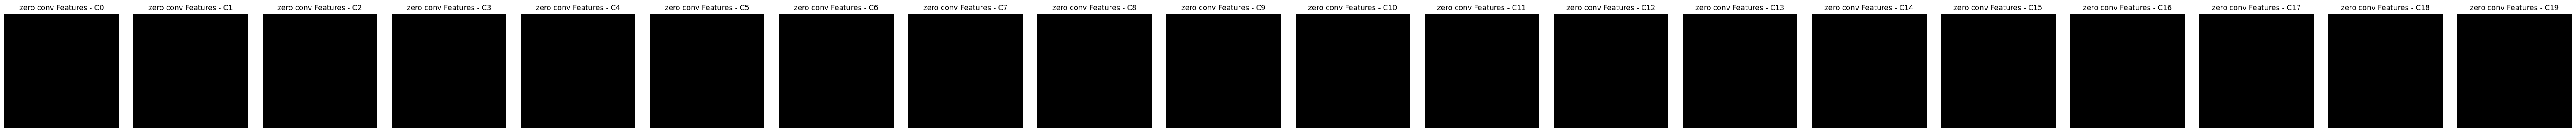

In [10]:
zc = feature_extractor.zero_convs[0](e1)
visualize_feature_maps(zc, title="zero conv Features", num_channels=20)